### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline

import os
import glob
import logging
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-01-24 12:30:16,289 root         INFO     all modules loaded


### Session parameters and raw files

In [4]:
reload(et)

bci_locations_dict = {'mnt': os.path.abspath('/mnt/cube/earneodo/bci_zf/neuropix/birds'),
                             'local': os.path.abspath('/mnt/cube/earneodo/scratch/raw_data'),
                             'fast': os.path.abspath('/mnt/cube/earneodo/scratch')
                             }

bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird, location_dict=bci_locations_dict)
all_bird_sess

['20201105', '20201106', '20201104']

In [5]:
sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201104',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'],
                              location_dict=bci_locations_dict)

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [6]:
sess_epochs = sglu.list_sgl_epochs(sess_par, location_dict=bci_locations_dict)
sess_epochs

2021-01-24 12:30:16,424 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'msort': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/mnt/cube/earneodo/scratch/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104/stream.kwd', 'kwik': '/mnt/cube/earneodo/scratch/raw_data/z_w12m7_20/Ephys/kwik/20201104/sort_2/spikes.kwik', 'kwe': 

['20201104_alles',
 '2500r250a_3500_dir_g0',
 '2500r250a_3500_dir_g1',
 '2500r250a_3500_dir_g2']

In [7]:
### pick a session
reload(sglu)
epoch = sess_epochs[-1] # g2 is the shortest

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])

In [8]:
sgl_folders

{'nidq': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2',
 'imec_0': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0'}

In [9]:
sgl_files

{'nidq': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_t0.nidq.meta'],
 'lf_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0/2500r250a_3500_dir_g2_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0/2500r250a_3500_dir_g2_t0.imec0.ap.meta']}

In [10]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


### view the nidaq data

In [11]:
run_recordings['nidq']

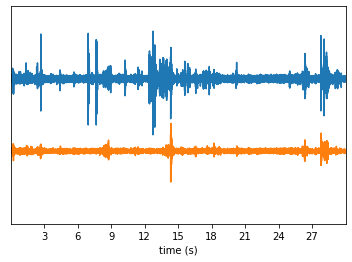

In [12]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 7], trange=[0,30])

In [13]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-01-24 12:30:17,097 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [14]:
run_recordings['lf_0']._raw.shape

(385, 334007)

In [15]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.039951258506555

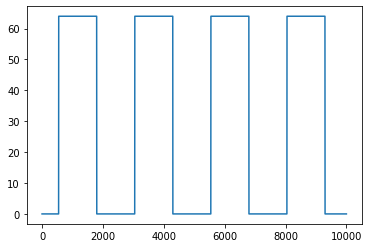

In [16]:
plt.plot(syn_ch_arr[:10000])

In [17]:
run_recordings['nidq']._meta

{'acqMnMaXaDw': '0,0,8,1',
 'appVersion': '20200520',
 'fileCreateTime': '2020-11-04T18:02:34',
 'fileName': 'D:/experiment/raw_data/z_w12m7_20/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_t0.nidq.bin',
 'fileSHA1': 'CC5AD211813880AC8B5E381E13E6D358E27D6DCD',
 'fileSizeBytes': '60120000',
 'fileTimeSecs': '133.60164363689287',
 'firstSample': '245080800',
 'gateMode': 'Immediate',
 'nDataDirs': '1',
 'nSavedChans': '9',
 'niAiRangeMax': '5',
 'niAiRangeMin': '-5',
 'niAiTermination': 'RSE',
 'niClockLine1': 'Internal',
 'niClockSource': 'PXI1Slot4_8ch_Int : 25000.000000',
 'niDev1': 'PXI1Slot4',
 'niDev1ProductName': 'PXIe-6363',
 'niMAChans1': '',
 'niMAGain': '1',
 'niMNChans1': '',
 'niMNGain': '200',
 'niMuxFactor': '32',
 'niSampRate': '24999.692437',
 'niStartEnable': 'false',
 'niStartLine': 'PXI1Slot4/port0/line0',
 'niXAChans1': '0:7',
 'niXDBytes1': '1',
 'niXDChans1': '0:7',
 'snsMnMaXaDw': '0,0,8,1',
 'snsSaveChanSubset': 'all',
 'syncNiChan': '0',
 'syncNiChanType'

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

2021-01-24 12:30:17,279 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


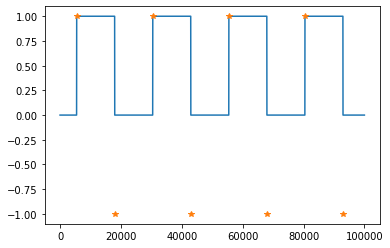

In [18]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

In [19]:
nidq_syn_ttl

(array([ 5435, 17935, 30435, 42935, 55435, 67935, 80435, 92934]),
 array([ 1, -1,  1, -1,  1, -1,  1, -1]))

2021-01-24 12:30:17,496 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:17,501 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 31.02592
2021-01-24 12:30:17,502 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:17,503 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:17,504 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 31.02592


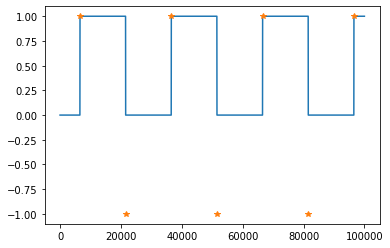

In [20]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [21]:
tuple([5, 7])

(5, 7)

In [22]:
run_recordings['ap_0'].get_traces()

memmap([[  9,   4,  14, ...,  12,  10,  16],
        [  9,   1,  -9, ...,   5,   3,   4],
        [ -3, -11, -15, ...,  -6, -11, -13],
        ...,
        [ 39,  37,  37, ...,   2,  -4,   3],
        [ 55,  55,  55, ...,  15,  15,  14],
        [ 31,  31,  30, ...,  -4,  -6,  -4]], dtype=int16)

In [23]:
ttl_arr = np.array(ap_syn_ttl)

In [24]:
ttl_arr[1]==-1

array([False,  True, False,  True, False,  True, False])

In [25]:
np.diff(ttl_arr[0, ttl_arr[1]==-1])

array([30000, 30000])

### The time syncronization

In [26]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [27]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.0

In [28]:
compute_sf(nidq_syn_ttl)

array([25000, 25000, 24999, 25000, 25000, 25000])

#### use the imec af as a pattern

In [29]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-24 12:30:17,714 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:17,717 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333
2021-01-24 12:30:17,719 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:17,720 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:17,721 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333


In [30]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

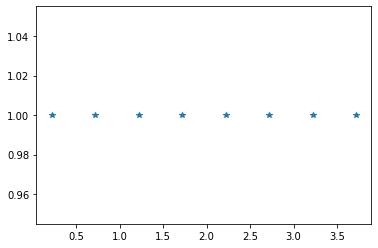

In [31]:
plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [32]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [33]:
ttl_edge_tuple_pattern[0].shape

(8,)

#### fit the nidaq to the pattern

In [34]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-24 12:30:17,878 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [35]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

array([5.21733333e-05, 9.21760000e-05, 1.32178667e-04, ...,
       1.33619071e+02, 1.33619111e+02, 1.33619151e+02])

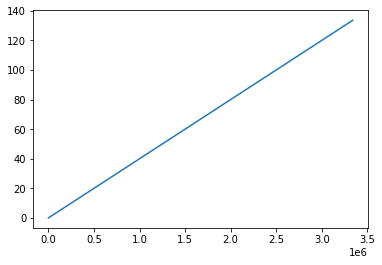

In [36]:
plt.plot(run_recordings[signal]._t_prime)

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [37]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-24 12:30:18,326 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:18,326 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:18,540 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-24 12:30:18,617 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:18,618 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:18,622 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.0399

In [38]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-24 12:30:18,641 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:18,642 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:18,691 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-24 12:30:18,766 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [39]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-24 12:30:18,921 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:18,922 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:18,971 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-24 12:30:19,043 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-24 12:30:19,044 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-24 12:30:19,094 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.0422

### Test the sync

##### plot all three times
should see different slopes, same end point

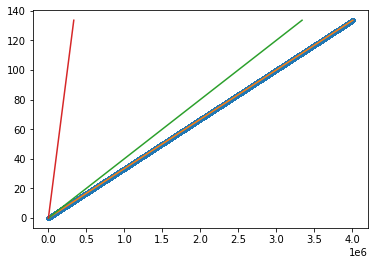

In [40]:
plt.plot(run_recordings['ap_0']._t_0, '.')
plt.plot(run_recordings['ap_0']._t_prime)
plt.plot(run_recordings['nidq']._t_prime)
plt.plot(run_recordings['lf_0']._t_prime)

In [41]:
run_recordings['lf_0']._t_prime[-1]

133.60224073604007

In [42]:
run_recordings['ap_0']._t_prime[-1]

133.60253305596652

In [43]:
run_recordings['nidq']._t_prime[-1]

133.6015515110232

In [45]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### plot the square syn signals in the three different timescales

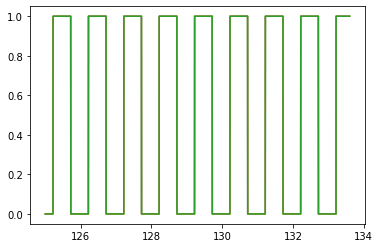

In [53]:
sig = 'lf_0'
t_start_plot = 125

t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

sig = 'ap_0'
t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

sig = 'nidq'
t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

#### fit the nidaq to the pattern

In [ ]:
signal = 'lf_0'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

In [ ]:
ttl_edge_tuple

In [ ]:
## find the points to interpolate

In [ ]:
t_prime = np.interp(np.arange(n_t), ttl_edge_tuple[0][:t_pattern_edge.size], t_pattern_edge)

In [ ]:
t_prime

In [ ]:
np.arange?

In [ ]:
plt.plot(t_prime)

In [ ]:
### try with scipy interp1d

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
t_interp_f = interp1d(ttl_edge_tuple[0][:t_pattern_edge.size], t_pattern_edge, 
                      assume_sorted=True, fill_value='extrapolate')

t_pprime = t_interp_f(np.arange(n_t))

In [ ]:
plt.plot(t_pprime)
plt.plot(t_prime)

In [ ]:
## plot them side by side with the same time scale

In [ ]:
plt.plot(t_pprime, syn_stream.flatten())

plt.plot(t_pattern, syn_stream_pattern.flatten())

### The sorting

In [ ]:
se.installed_recording_extractor_list

In [ ]:
se.KiloSortRecordingExtractor?